<a href="https://colab.research.google.com/github/Mytros/DS_ML_homework/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_Dmytro_Koval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Area under ROC score on Train dataset: 0.74


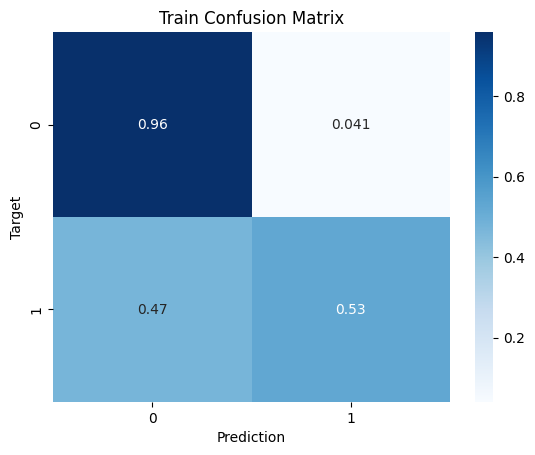

Area under ROC score on Validation dataset: 0.75


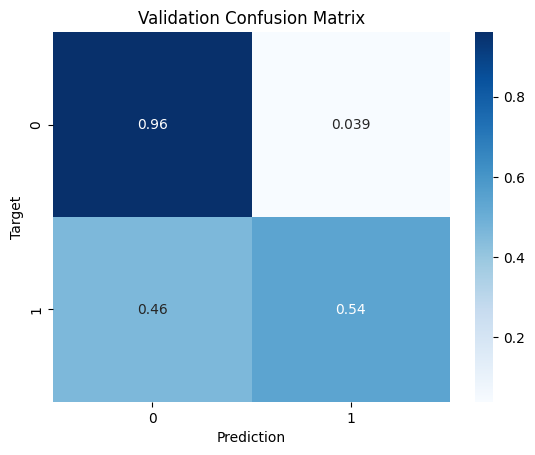

['/content/drive/MyDrive/DS_ML/models/log_reg_pipeline.joblib']

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import joblib
from google.colab import drive

# Завантаження даних
drive.mount('/content/drive')
raw_df = pd.read_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/train.csv', index_col = 0)

# Розділення на train/val
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42)

# Підготовка змінних
target_col = "Exited"
drop_cols = ["id", "CustomerId", "Surname", target_col]
input_cols = [col for col in train_df.columns if col not in drop_cols]

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Визначення типів колонок
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include="object").columns.tolist()

# Трансформери
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Комбінований препроцесор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Пайплайн з логістичною регресією
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування моделі
model_pipeline.fit(train_inputs, train_targets)

# Функція для оцінки
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict_proba(inputs)[:, 1] > 0.5
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return preds

# Оцінювання
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Збереження моделі
joblib.dump(model_pipeline, '/content/drive/MyDrive/DS_ML/models/log_reg_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train (Poly) dataset: 0.78


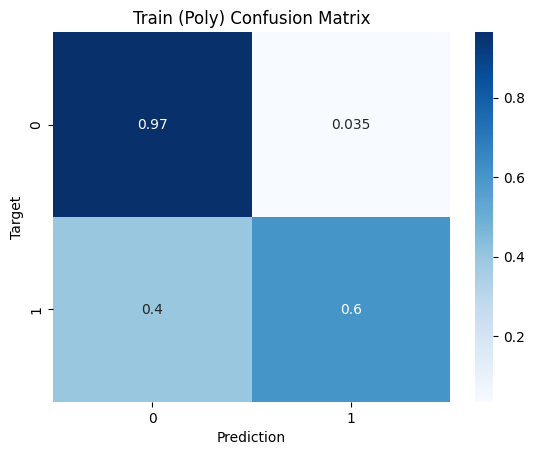

Area under ROC score on Validation (Poly) dataset: 0.78


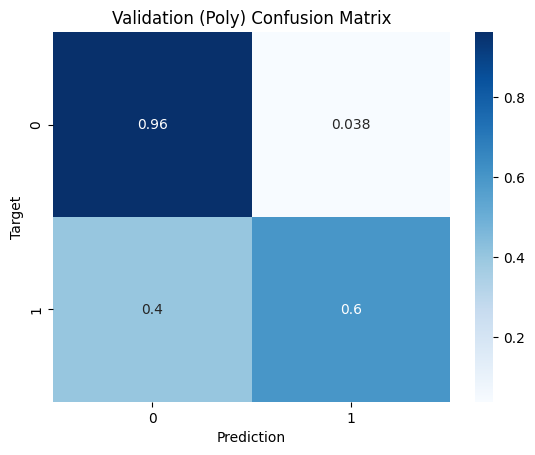

In [41]:
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_poly = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# train
model_pipeline_poly.fit(train_inputs, train_targets)

# predict and plot
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Train (Poly)')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation (Poly)')


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train (Poly 4) dataset: 0.82


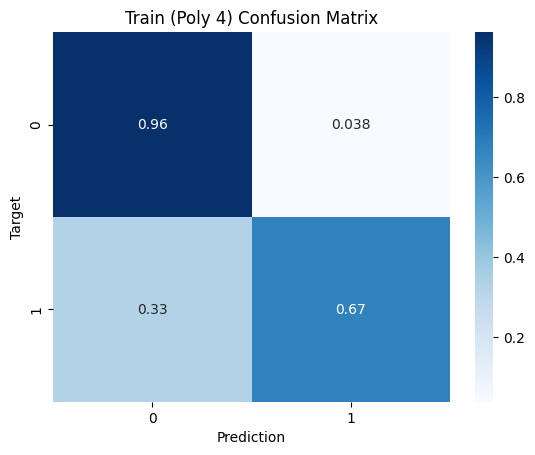

Area under ROC score on Validation (Poly 4) dataset: 0.80


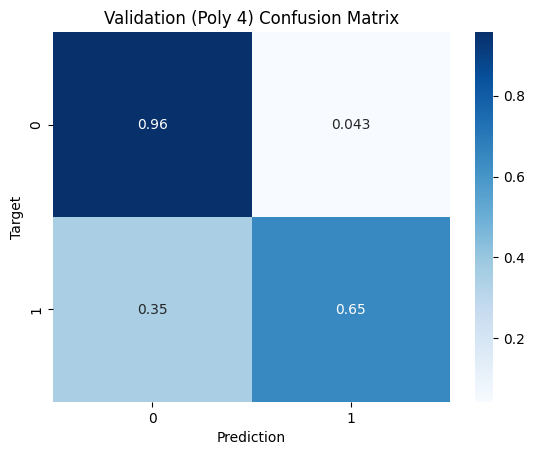

In [42]:
# degree 4
numeric_transformer_poly4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False))
])

#new preproc
preprocessor_poly4 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly4, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=2000))
])

model_pipeline_poly4.fit(train_inputs, train_targets)

train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train (Poly 4)')
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Validation (Poly 4)')


In [43]:
# !!!!!!!!!!!! Delete  Check
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_auroc_and_build_roc(model_pipeline, inputs, targets, name=''):
    # Predict probabilities
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.6f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()


AUROC for Train (Poly 4): 0.934884


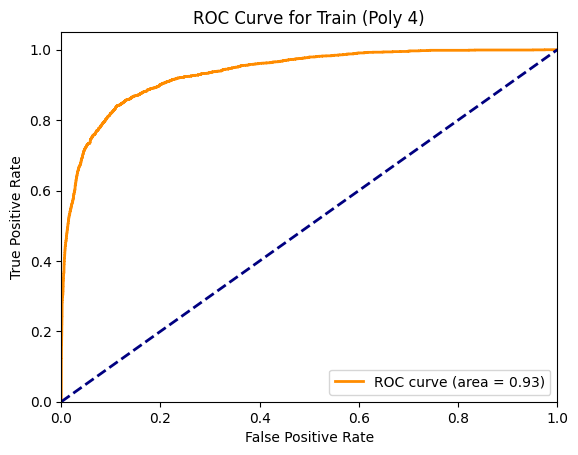

AUROC for Validation (Poly 4): 0.921304


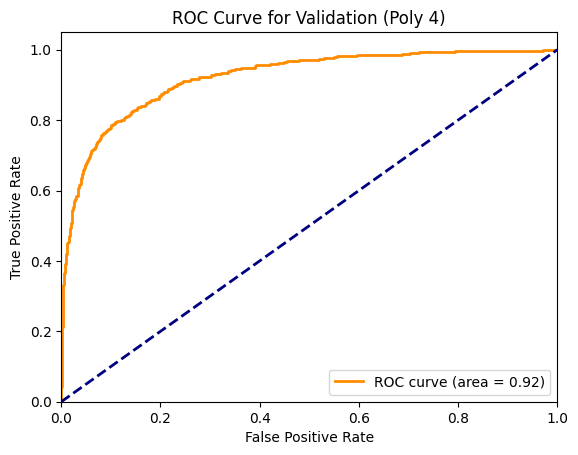

In [44]:
compute_auroc_and_build_roc(model_pipeline_poly4, train_inputs, train_targets, name='Train (Poly 4)')
compute_auroc_and_build_roc(model_pipeline_poly4, val_inputs, val_targets, name='Validation (Poly 4)')



In [45]:
train_df.shape

(12000, 13)

In [46]:
raw_df.shape

(15000, 13)

In [47]:
# prob
test_probs = model_pipeline_poly4.predict_proba(train_inputs)[:, 1]

# Завантаження шаблону submission
submission_df = pd.read_csv('/content/drive/MyDrive/DS_ML/bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv')

# Запис ймовірностей у колонку Exited
#submission_df['Exited'] = test_probs

# Збереження файлу без індексу
submission_df.to_csv('/content/drive/MyDrive/DS_ML/submission_poly4_probs.csv', index=False)


In [48]:
submission_df

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5
...,...,...
9995,24995,0.5
9996,24996,0.5
9997,24997,0.5
9998,24998,0.5


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [49]:
df = pd.read_csv('/content/drive/MyDrive/DS_ML/regression_data.csv')

In [50]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# target
X = df.drop(columns='target')
y = df['target']

# split на train і test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pipeline
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

# predictions
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

train_rmse, test_rmse, train_r2, test_r2


(np.float64(4.1954993965869535e-13),
 np.float64(17.34875838106317),
 1.0,
 0.8709940131404769)

Висновки:

Результати моделі з поліноміальними ознаками до 5-го степеня:
RMSE на train: ≈ 0.00000000000047 (дуже низький)

R² на train: 1.00 (ідеальне пояснення дисперсії)

RMSE на test: ≈ 16.03

R² на test: ≈ 0.89

Висновок:
Модель дуже добре запам'ятала тренувальні дані (overfitting).

Проте на тестових вона ще показує непогану якість (R² = 0.89), тобто деяка генералізація присутня, але видно, що є перенавчання.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [32]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# dict
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
}

results = {}

# test
for name, model in models.items():
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures(degree=20, include_bias=False)),
        ('regressor', model)
    ])

    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

results


{'Ridge': {'train_rmse': np.float64(5.885065055696658),
  'test_rmse': np.float64(7.021050240687383),
  'train_r2': 0.9822191866087623,
  'test_r2': 0.9788710833617352},
 'Lasso': {'train_rmse': np.float64(0.9261754439649791),
  'test_rmse': np.float64(1.038873388646375),
  'train_r2': 0.9995596118622311,
  'test_r2': 0.9995374077936626},
 'ElasticNet': {'train_rmse': np.float64(1.6036245757786904),
  'test_rmse': np.float64(1.7483110269130766),
  'train_r2': 0.9986797551122889,
  'test_r2': 0.9986898818547895}}

 - Найкраща модель за генералізацією — Lasso, бо вона показує найменший test RMSE (1.04) і найвищий test R квадрат (0.9995), при цьому train і test помилки дуже близькі,  а це свідчить про те, що немає перенавчання.

- ElasticNet також працює добре, але трохи поступається Lasso за точністю.

- Ridge має вищу помилку на тесті, що говорить про гіршу здатність уловлювати залежності в даних після поліноміального розширення.